In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
from scipy import stats
from scipy.optimize import minimize
from sklearn.neural_network import MLPRegressor

In [2]:
# Import data
x_df=pd.read_csv(r'x_df.csv')
x_df.index=list(map(lambda x:dt.datetime.strptime(x,'%Y-%m-%d'),x_df.iloc[:,0]))
x_df.drop(x_df.columns[0],axis=1,inplace=True)
y_df=pd.read_csv(r'y_df.csv')
y_df.index=list(map(lambda x:dt.datetime.strptime(str(x),'%Y/%m/%d'),y_df.iloc[:,0]))
y_df.drop(y_df.columns[0],axis=1,inplace=True)
y_df.shift(-1)
# Convert the close of sz50 and zz1000 to return
for col in ['hg1','gc1','sz50','zz1000']:
    x_df[col]=x_df[col].pct_change()
for icol in range(14):
    x_df.iloc[:,icol]=x_df.iloc[:,icol]*0.01
x_df.dropna(axis=0,inplace=True)

# Get same period
y_df=y_df.loc[x_df.index]

#y_df=y_df.shift(-1).copy()
#y_df.dropna(inplace=True)
#x_df=x_df.loc[y_df.index]


In [3]:
'''
1. Functions
'''
#1.1 Remove outliers
def outliers(df):   
    def process_outliers(value,min_val,max_val):
        if (value>=min_val)&(value<=max_val):
            return value
        elif value<min_val:
            return min_val
        else: 
            return max_val
        
    outliers=df.copy()
    cols=df.columns
    
    for col in cols:
        icol=df[col].copy()
        min_val=icol.mean()-3*icol.std()
        max_val=icol.mean()+3*icol.std()
        outliers[col]=list(map(lambda x:process_outliers(x,min_val,max_val),icol))
    
    return outliers    

#1.2 Plot netvalue series based on return series
def plot_nv(returns):
    fig=plt.figure()
    if type(returns)==type([]):        
        returns=pd.concat(returns,axis=1)
    plt.plot((1+returns).cumprod())
    if (type(returns))==type(pd.Series(np.ones(10))):
        plt.legend(loc='upper left',labels=[returns.name])
        plt.show()

    
    else:
        plt.legend(loc='upper left',labels=returns.columns.tolist())
        plt.show()
    
#1.3 Conduct OLS to x_set and y_set
def ols(y_set,raw_x_set,print_model=True):
    if type(raw_x_set)==type([]):
        x_set=pd.concat(raw_x_set,axis=1)
        x_set_name=[]
        for ix in raw_x_set:
            x_set_name.append(ix.name)
        x_set.columns=x_set_name
    else:
        x_set=raw_x_set.copy()
    model=sm.OLS(y_set,sm.add_constant(x_set)).fit()
    if print_model==True:
        print(model.summary())
    return model

#1.4 Print Levene test result
def levene(sample1,sample2):
    print(stats.levene(sample1,sample2))
    
#1.5 Print T-test result of two independt samples
def ttest_ind(sample1,sample2,equal_var=False):
    print(stats.ttest_ind(sample1,sample2,equal_var=equal_var))

#1.6 Convert numpy.datetime64 to datetime.datetime
def dt64todatetime(dt64):
    return dt.datetime.utcfromtimestamp(pd.Timestamp(dt64).timestamp())

#1.7 Calculate return series and netvalue series from weight dataframe
def cal_rts_nv(wts,y_return,name='strategy'):
    rts=wts.multiply(y_return).sum(axis=1)
    rts.name='rts_%s'%name
    nv=(1+rts).cumprod()
    nv.name='nv_%s'%name    
    return rts,nv

#1.8 Apply MLP_regressor of Neural Networks
def MLP_regressor(x_train,y_train,x_set):
    clf = MLPRegressor(activation='identity',solver='sgd',alpha=1e-5,hidden_layer_sizes=(50,50), random_state=1)
    clf.fit(x_train,y_train)
    y_set = pd.DataFrame(clf.predict(x_set),index=x_set.index,columns=y_train.columns)
    
    return np.abs(y_set)

#1.9 Calculate performance of different strategies
def performance(returns):
    # Cumulative return
    df=(1+returns).cumprod()
    cumulative_return=round((df.iloc[-1,:]-df.iloc[0,:])/df.iloc[0,:]*100,2)
    # Annual return
    annual_return=((1+cumulative_return/100)**(250/df.shape[0])-1)*100

    # Annual volatility
    volatility=np.sqrt(returns.std()*250)
    
    performance=pd.concat([cumulative_return,annual_return,volatility],axis=1)
    performance.columns=['累计收益率(%)','年化收益率(%)','年化波动率']
    
    return performance
    

In [4]:
'''
2. Test prediction ability
'''
y_test=y_df[['SIZE','MOMENTUM','SIZENL','LIQUIDTY']].copy()    
x_test=x_df.iloc[:,14:].copy()


In [5]:
'''
    2.1 LIQUIDTY 
'''
# Test the prediction ability of volume to liquidty
#
# Conclusion: 
#
# 1. Liquidty factor depends on the transaction volume spread 
# of large-cap stocks instead of small-cap stocks, which means sz50>zz1000
#
# 2. Prediction on liquidty factor on the next day is more accurate than on the following days
#
# 3. Parameters: shift(-1), ewm(halflife=5)

sz50m=x_test['sz50m'].copy()
zz1000m=x_test['zz1000m'].copy()
#sz50ms=((sz50m-sz50m.ewm(halflife=20).mean())/10e10).copy()
liquidty=y_test['LIQUIDTY'].copy()


mspread=((sz50m-sz50m.ewm(halflife=5).mean())/10e10).copy()

print(np.corrcoef((liquidty.shift(-1).dropna()).rolling(window=20).std().dropna(),
            (mspread.iloc[:-1].dropna()).rolling(window=20).std().dropna()))
print(np.corrcoef((liquidty.shift(-20).dropna()).rolling(window=20).std().dropna(),
            (mspread.iloc[:-20].dropna()).rolling(window=20).std().dropna()))


[[1.        0.3109973]
 [0.3109973 1.       ]]
[[1.         0.18991977]
 [0.18991977 1.        ]]


In [6]:
'''
    2.2 SIZE
'''

# Parameters: win=1,hl=1

size=y_test['SIZE'].copy()
raw_ratio=np.log(1+x_test['sz50'])-np.log(1+x_test['zz1000'])
#raw_ratio2=np.log(x_test['sz50m']/x_test['zz1000m'])
#ratio2=raw_ratio2.ewm(halflife=20).mean()
raw_ratio.name='raw_ratio'
#rs=pd.DataFrame(list(zip(size,raw_ratio2)),columns=['size','raw_ratio2'],index=raw_ratio2.index)
#plot_nv(rs)

ratio=raw_ratio.ewm(halflife=1).mean()/10
sz_rt=pd.DataFrame(list(zip(size.shift(-1),ratio)),index=size.index,columns=['size','ratio']).dropna()

print(np.corrcoef((size.shift(-1).dropna()).rolling(window=20).std().dropna(),
            (ratio.iloc[:-1].dropna()).rolling(window=20).std().dropna()))
print(np.corrcoef((size.shift(-20).dropna()).rolling(window=20).std().dropna(),
            (ratio.iloc[:-20].dropna()).rolling(window=20).std().dropna()))



[[1.         0.86554786]
 [0.86554786 1.        ]]
[[1.         0.45300951]
 [0.45300951 1.        ]]


In [7]:
sizenl=y_test['SIZENL'].copy()

ratios=pd.Series(np.dot(pd.concat([pd.Series(np.ones(ratio.shape[0]),index=ratio.index),ratio,ratio**2],axis=1),(ols(sizenl,[ratio,ratio**2],False)).params),
                 index=ratio.index,name='ratios')

print(np.corrcoef((sizenl.shift(-1).dropna()).rolling(20).std().dropna(),(ratios.iloc[:-1]).rolling(20).std().dropna()))
print(np.corrcoef((sizenl.shift(-20).dropna()).rolling(20).std().dropna(),(ratios.iloc[:-20]).rolling(20).std().dropna()))



[[1.         0.68810178]
 [0.68810178 1.        ]]
[[1.        0.4025812]
 [0.4025812 1.       ]]


In [8]:
'''
    2.4 MOMENTUM
'''

mom=y_test['MOMENTUM'].copy()

L=180
S=20
hl=120

#for L in [60,120,180,240,250,360,500]:
    #print('L: %d'%L)
    #for hl in [20,60,120,180]:
        #print('hl: %d'%hl)

sz50_mom=((np.log(1+x_test['sz50']).ewm(halflife=hl).mean()).rolling(window=L).sum()-
          (np.log(1+x_test['sz50'].ewm(halflife=hl).mean())).rolling(window=S).sum()).dropna()        

print(np.corrcoef((mom.iloc[(L-1):].shift(-1).dropna()).rolling(window=20).std().dropna(),
                  sz50_mom.iloc[:-1].rolling(window=20).std().dropna())[0][1])

print(np.corrcoef((mom.iloc[(L-1):].shift(-20).dropna()).rolling(window=20).std().dropna(),
                  sz50_mom.iloc[:-20].rolling(window=20).std().dropna())[0][1])

mymom=sz50_mom.copy()

0.11480474488677453
0.13279785281613182


In [9]:

'''
3. Backtesting
'''


# Find all days for adjusting positions
all_trading_days=pd.Series(x_df.index[x_df.index>=dt.datetime(2009,12,1)])

adjust_days=[]
start_days=[]
start_days.append(all_trading_days[0])
for i in range(1,all_trading_days.shape[0]):
    if all_trading_days[i].month!=all_trading_days[i-1].month:
        adjust_days.append(all_trading_days[i-1])
        start_days.append(all_trading_days[i])

del start_days[-1]

backtest_startday=dt.datetime(2012,12,31)
backtest_endday=dt.datetime(2020,9,30)
cal_period=pd.DataFrame(zip(start_days,adjust_days),columns=['start','end'])


# 4 input factors, 4 output factors
x_base=x_df[['sz50','sz50m','zz1000','zz1000m']].copy()
y_base=y_df[['LIQUIDTY','SIZE','SIZENL','MOMENTUM']].copy()
# Reverse the sign of momentum because it is the only positive factor among these four factors
y_base['MOMENTUM']=-y_base['MOMENTUM']
y_return=y_base.iloc[np.where((y_base.index>backtest_startday)&(y_base.index<=backtest_endday))].copy()
y_return['MOMENTUM']=-y_return['MOMENTUM']

# Backtesting main function
def adjust_weight(x_base,y_base,adjust_day,cal_period,strategy='strategy1'):
    start_date_64,end_date_64=cal_period[cal_period['end']==adjust_day].values[0]              
    start_date=dt64todatetime(start_date_64)
    end_date=dt64todatetime(end_date_64)
    
    # Generate weights for minvariance portflios
    if strategy=='minvar':                    
        cov=y_base.loc[start_date:end_date].cov()       
        
        def fun(x):
            var=np.dot(np.dot(x,cov),x)
            return var*1000000
        
        x0=np.ones(y_return.shape[1])/y_return.shape[1]
        cons={'type':'eq','fun':lambda x:x.sum()-1}
        bnds=tuple((-1,1) for i,j in zip((-1)*np.ones(y_return.shape[1]),np.ones(y_return.shape[1])))
        res=minimize(fun,x0,method='SLSQP',constraints=cons,tol=1e-3,bounds=bnds)
        w=res.x       
        
 
    # Generate weights for portfolios with strategy1
    if strategy=='strategy1':

        # Extract train set and test set from x_base and y_base
        # x: 20 days' rolling standard deviation
        # y: 20 days' rolling standard deviation before 20 days
        x_train=x_base[x_base.index<end_date].rolling(window=20).std().dropna().copy()
        y_train=y_base.shift(-20).rolling(window=20).std().dropna().loc[x_train.index].copy()

        x_train.fillna(method='ffill',inplace=True)
        y_train.fillna(method='ffill',inplace=True)
        x_train=outliers(x_train)
        y_train=outliers(y_train)

        x_set=x_base.rolling(window=20).std().dropna()[start_date:end_date].copy()
        y_set=MLP_regressor(x_train,y_train,x_set)

        # Optimization object: minimum average volatility of 4 factors
        def fun(x):
            var=y_set.mean().multiply(x).sum()
            return var*1000000


        x0=np.ones(y_return.shape[1])/y_return.shape[1]
        cons={'type':'eq','fun':lambda x:x.sum()-1}
        bnds=tuple((-1,1) for i,j in zip((-1)*np.ones(y_return.shape[1]),np.ones(y_return.shape[1])))
        res=minimize(fun,x0,method='SLSQP',constraints=cons,tol=1e-3,bounds=bnds)
        w=res.x
    return w



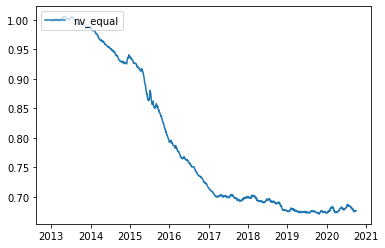

In [10]:
'''
     3.1 Equal weights
'''
# Generate weights of equal weights portfolio
wts_equal=pd.DataFrame([np.ones(y_return.shape[1])/y_return.shape[1] for i in range(y_return.shape[0])],index=y_return.index,columns=y_return.columns)
rts_equal,nv_equal=cal_rts_nv(wts_equal,y_return,'equal')

fig=plt.figure()
plt.plot(nv_equal)
plt.legend(loc='upper left',labels=[nv_equal.name])
plt.show()

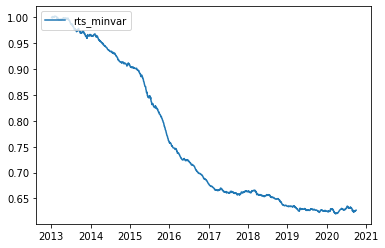

In [11]:
'''
    3.2 Min variance
'''


# Backtesting. If today is the last trading day in this month, adjust position by
# calculating portofolio weights for next month
    
wts_minvar=pd.DataFrame(index=y_return.index,columns=y_return.columns)

# Backtesting: 
for i in range(wts_minvar.shape[0]):
    if i==0:
        wts=adjust_weight(x_base,y_base,backtest_startday,cal_period,strategy='minvar')
        wts_minvar.iloc[i,:]=wts.copy()       
    elif wts_minvar.index[i-1] in adjust_days:
        wts=adjust_weight(x_base,y_base,wts_minvar.index[i-1],cal_period,strategy='minvar')
        wts_minvar.iloc[i,:]=wts.copy()
    else:
        wts_minvar.iloc[i,:]=wts_minvar.iloc[i-1,:].copy()
   
rts_minvar,nv_minvar=cal_rts_nv(wts_minvar,y_return,'minvar')

plot_nv(rts_minvar)

0.00% finished!
5.48% finished!
10.96% finished!
16.45% finished!
21.93% finished!
27.41% finished!
32.89% finished!
38.38% finished!
43.86% finished!
49.34% finished!
54.82% finished!
60.31% finished!
65.79% finished!
71.27% finished!
76.75% finished!
82.24% finished!
87.72% finished!
93.20% finished!
98.68% finished!
Completion!


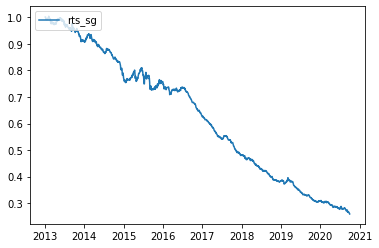

In [12]:
'''
     3.3 My Strategy
'''
# Construct indicators: mspread, ratio, ratio_square,mymom
mspread=((x_test['sz50m']-x_test['sz50m'].ewm(halflife=5).mean())/10e10).copy()
mspread.name='mspread'
raw_ratio=np.log(1+x_test['sz50'])-np.log(1+x_test['zz1000'])
ratio=raw_ratio.ewm(halflife=1).mean()/10
ratio.name='ratio'
ratio_square=ratio**2
ratio_square.name='ratio-square'
L=180
S=20
hl=120
mymom=((np.log(1+x_test['sz50']).ewm(halflife=hl).mean()).rolling(window=L).sum()-
          (np.log(1+x_test['sz50'].ewm(halflife=hl).mean())).rolling(window=S).sum()).dropna()        
mymom.name='mymom'
indicators=pd.concat([mspread,ratio,ratio_square,mymom],axis=1).dropna()


wts_sg=pd.DataFrame(index=y_return.index,columns=y_return.columns)

# Backtesting: 
for i in range(wts_sg.shape[0]):
    if i==0:
        wts=adjust_weight(indicators,y_base,backtest_startday,cal_period)
        wts_sg.iloc[i,:]=wts.copy()       
    elif wts_sg.index[i-1] in adjust_days:
        wts=adjust_weight(indicators,y_base,wts_sg.index[i-1],cal_period)
        wts_sg.iloc[i,:]=wts.copy()
    else:
        wts_sg.iloc[i,:]=wts_sg.iloc[i-1,:].copy()
    if (i%100)==0:
        print('%.2f%% finished!\r'%(i*1.0/wts_sg.shape[0]*100))
print('Completion!')   
rts_sg,nv_sg=cal_rts_nv(wts_sg,y_return,'sg')
plot_nv(rts_sg)

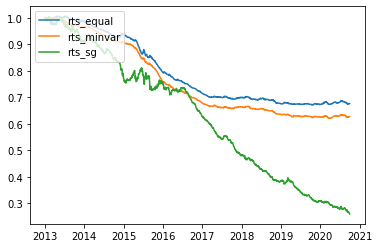

            累计收益率(%)   年化收益率(%)     年化波动率
rts_equal     -32.33  -5.211890  0.484156
rts_minvar    -37.21  -6.179318  0.476754
rts_sg        -74.07 -16.889681  0.954888


In [13]:
'''
    3.4 Results
'''
plot_nv([rts_equal,rts_minvar,rts_sg])
rts_df=pd.concat([rts_equal,rts_minvar,rts_sg],axis=1)
nv_df=pd.concat([nv_equal,nv_minvar,nv_sg],axis=1)
print(performance(rts_df))


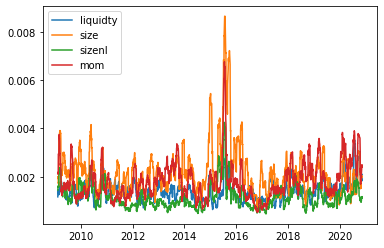

LeveneResult(statistic=430.19374507851137, pvalue=4.3452018028206516e-92)
LeveneResult(statistic=421.9165741806892, pvalue=2.0454451911739794e-90)
LeveneResult(statistic=337.2491270266587, pvalue=3.6436513166260036e-73)
LeveneResult(statistic=296.08829002133916, pvalue=1.1023656333184942e-64)
Ttest_indResult(statistic=38.43461136929132, pvalue=4.320889091939403e-272)
Ttest_indResult(statistic=25.092304632107318, pvalue=1.0443240884407999e-129)
Ttest_indResult(statistic=48.65886246044702, pvalue=0.0)
Ttest_indResult(statistic=37.87614673986625, pvalue=1.130286707733755e-273)


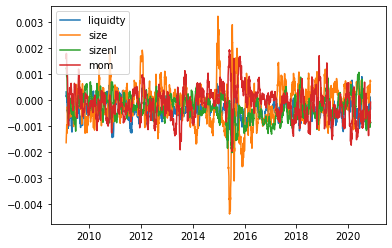

LeveneResult(statistic=688.6442290361964, pvalue=3.7013308089633826e-143)
LeveneResult(statistic=500.2063145472743, pvalue=3.8339393516309575e-106)
LeveneResult(statistic=302.0808371678409, pvalue=6.36329475822634e-66)
LeveneResult(statistic=108.18063789450036, pvalue=4.174991630002394e-25)
Ttest_indResult(statistic=15.319224224378907, pvalue=1.8991122843015048e-51)
Ttest_indResult(statistic=21.104854597859834, pvalue=2.315151687270191e-94)
Ttest_indResult(statistic=7.946600867473484, pvalue=2.4116562368150815e-15)
Ttest_indResult(statistic=11.315978484529468, pvalue=2.3942782928967037e-29)


In [14]:
'''
4. Extra Questions
'''
'''
    4.1 Identify offensive factors and defensive factors
'''

# Volatility of four factors
# window=20
mom=-mom
liquidty_20std=liquidty.rolling(window=20).std().dropna()
size_20std=size.rolling(window=20).std().dropna()
sizenl_20std=sizenl.rolling(window=20).std().dropna()
mom_20std=mom.rolling(window=20).std().dropna()

fig=plt.figure()
plt.plot(liquidty_20std)
plt.plot(size_20std)
plt.plot(sizenl_20std)
plt.plot(mom_20std)
plt.legend(loc='upper left',labels=['liquidty','size','sizenl','mom'])
plt.show()

# Test if two population have the same variance
levene(size_20std,liquidty_20std)
levene(mom_20std,liquidty_20std)
levene(size_20std,sizenl_20std)
levene(mom_20std,sizenl_20std)

# Test result suggests that they have different variance
ttest_ind(size_20std,liquidty_20std)
ttest_ind(mom_20std,liquidty_20std)
ttest_ind(size_20std,sizenl_20std)
ttest_ind(mom_20std,sizenl_20std)


# Return of four factors
# window=20


liquidty_20mean=liquidty.rolling(window=20).mean().dropna()
size_20mean=size.rolling(window=20).mean().dropna()
sizenl_20mean=sizenl.rolling(window=20).mean().dropna()
mom_20mean=mom.rolling(window=20).mean().dropna()



fig=plt.figure()
plt.plot(liquidty_20mean)
plt.plot(size_20mean)
plt.plot(sizenl_20mean)
plt.plot(mom_20mean)
plt.legend(loc='upper left',labels=['liquidty','size','sizenl','mom'])
plt.show()


# Test if two population have the same variance
levene(size_20mean,liquidty_20mean)
levene(mom_20mean,liquidty_20mean)
levene(size_20mean,sizenl_20mean)
levene(mom_20mean,sizenl_20mean)

# Test result suggests that they have different variance
ttest_ind(size_20mean,liquidty_20mean)
ttest_ind(mom_20mean,liquidty_20mean)
ttest_ind(size_20mean,sizenl_20mean)
ttest_ind(mom_20mean,sizenl_20mean)


In [15]:
'''
    4.2 Test
'''
def adjust_weight2(x_base,y_base,adjust_day,cal_period,strategy='strategy1'):
    start_date_64,end_date_64=cal_period[cal_period['end']==adjust_day].values[0]              
    start_date=dt64todatetime(start_date_64)
    end_date=dt64todatetime(end_date_64)
    
    # Generate weights for minvariance portflios
    if strategy=='minvar':                    
        cov=y_base.loc[start_date:end_date].cov()       
        
        def fun(x):
            var=np.dot(np.dot(x,cov),x)
            return var*1000000
        
        x0=np.ones(y_return.shape[1])/y_return.shape[1]
        cons={'type':'eq','fun':lambda x:x.sum()-1}
        bnds=tuple((0,1) for i,j in zip(np.zeros(y_return.shape[1]),np.ones(y_return.shape[1])))
        res=minimize(fun,x0,method='SLSQP',constraints=cons,tol=1e-3,bounds=bnds)
        w=res.x       
        
    # Generate weights for portfolios with strategy1
    if strategy=='strategy1':
        
        # Extract train set and test set from x_base and y_base
        # x: 20 days' rolling standard deviation
        # y: 20 days' rolling standard deviation before 20 days
        x_train=x_base[x_base.index<end_date].rolling(window=20).std().dropna().copy()
        y_train=y_base.shift(-20).rolling(window=20).std().dropna().loc[x_train.index].copy()
        
        x_train.fillna(method='ffill',inplace=True)
        y_train.fillna(method='ffill',inplace=True)
        x_train=outliers(x_train)
        y_train=outliers(y_train)

        x_set=x_base.rolling(window=20).std().dropna()[start_date:end_date].copy()
        y_set=MLP_regressor(x_train,y_train,x_set)

        # Optimization object: minimum average volatility of 4 factors
        def fun(x):
            var=y_set.mean().multiply(x).sum()
            return var*1000000
        
        
        x0=np.ones(y_return.shape[1])/y_return.shape[1]
        cons={'type':'eq','fun':lambda x:x.sum()-1}
        bnds=tuple((0,1) for i,j in zip(np.zeros(y_return.shape[1]),np.ones(y_return.shape[1])))
        res=minimize(fun,x0,method='SLSQP',constraints=cons,tol=1e-3,bounds=bnds)
        w=res.x 
        
        
    # Generate weights for portfolios with strategy2
    if strategy=='strategy2':
        
        # Extract train set and test set from x_base and y_base
        # x: 20 days' rolling standard deviation
        # y: 20 days' rolling standard deviation before 20 days
        x_train=x_base[x_base.index<end_date].rolling(window=20).std().dropna().copy()
        y_train=y_base.shift(-20).rolling(window=20).std().dropna().loc[x_train.index].copy()
        
        x_train.fillna(method='ffill',inplace=True)
        y_train.fillna(method='ffill',inplace=True)
        x_train=outliers(x_train)
        y_train=outliers(y_train)

        x_set=x_base.rolling(window=20).std().dropna()[start_date:end_date].copy()
        y_set=MLP_regressor(x_train,y_train,x_set)
            
        if (y_set.mean()['SIZE']>=np.percentile(y_train['SIZE'],75))&(
                y_set.mean()['MOMENTUM']>=np.percentile(y_train['MOMENTUM'],75)):
            w=pd.Series([0.5,0,0,0.5],index=['LIQUIDTY','SIZE','SIZENL','MOMENTUM'])
        else:
            w=pd.Series([0,0.5,0.5,0],index=['LIQUIDTY','SIZE','SIZENL','MOMENTUM'])
                   
    return w

    


# Construct indicators: mspread, ratio, ratio_square,mymom
mspread=((x_test['sz50m']-x_test['sz50m'].ewm(halflife=5).mean())/10e10).copy()
mspread.name='mspread'
raw_ratio=np.log(1+x_test['sz50'])-np.log(1+x_test['zz1000'])
ratio=raw_ratio.ewm(halflife=1).mean()/10
ratio.name='ratio'
ratio_square=ratio**2
ratio_square.name='ratio-square'
L=180
S=20
hl=120
mymom=((np.log(1+x_test['sz50']).ewm(halflife=hl).mean()).rolling(window=L).sum()-
          (np.log(1+x_test['sz50'].ewm(halflife=hl).mean())).rolling(window=S).sum()).dropna()        
mymom.name='mymom'
indicators=pd.concat([mspread,ratio,ratio_square,mymom],axis=1).dropna()


wts_sg2=pd.DataFrame(index=y_return.index,columns=y_return.columns)

# Backtesting: 
for i in range(wts_sg2.shape[0]):
    if i==0:
        wts=adjust_weight2(indicators,y_base,backtest_startday,cal_period,strategy='strategy2')
        wts_sg2.iloc[i,:]=wts.copy()       
    elif wts_sg2.index[i-1] in adjust_days:
        wts=adjust_weight2(indicators,y_base,wts_sg2.index[i-1],cal_period,strategy='strategy2')
        wts_sg2.iloc[i,:]=wts.copy()
    else:
        wts_sg2.iloc[i,:]=wts_sg2.iloc[i-1,:].copy()
    if (i%100)==0:
        print('%.2f%% finished!\r'%(i*1.0/wts_sg2.shape[0]*100))

print('Completion!')      
rts_sg2,nv_sg2=cal_rts_nv(wts_sg2,y_return,'sg2')

0.00% finished!
5.48% finished!
10.96% finished!
16.45% finished!
21.93% finished!
27.41% finished!
32.89% finished!
38.38% finished!
43.86% finished!
49.34% finished!
54.82% finished!
60.31% finished!
65.79% finished!
71.27% finished!
76.75% finished!
82.24% finished!
87.72% finished!
93.20% finished!
98.68% finished!
Completion!


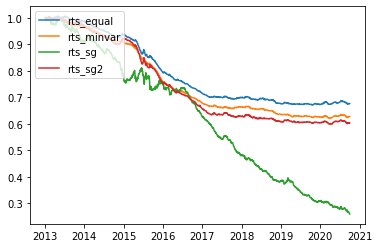

            累计收益率(%)   年化收益率(%)     年化波动率
rts_equal     -32.33  -5.211890  0.484156
rts_minvar    -37.21  -6.179318  0.476754
rts_sg        -74.07 -16.889681  0.954888
rts_sg2       -39.58  -6.672781  0.572439


In [16]:
'''
    4.3 Performance    
'''

plot_nv([rts_equal,rts_minvar,rts_sg,rts_sg2])

rts_df=pd.concat([rts_equal,rts_minvar,rts_sg,rts_sg2],axis=1)
nv_df=pd.concat([nv_equal,nv_minvar,nv_sg,nv_sg2],axis=1)

print(performance(rts_df))
    